In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import sys, os
from tqdm import tqdm

from utils import kb, c, h
from data_processing import DataProcessor
from fdtd_solver import FDTDSolver
from solar_index import SolarIndex
from scipy.integrate import trapezoid

from fdtd_solver import FDTDSolver
from RF_index import RFIndex
import rl_utils

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Check CUDA
 
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: Quadro M1000M


In [3]:
class SESimulation:
    def __init__(self, layer_materials, layer_thicknesses, solver):

        self.layer_materials = layer_materials
        self.layer_thicknesses = layer_thicknesses
        self.fdtd_solver = solver

        # Define frequency vectors for simulation
        self.f_vector = np.linspace(8e9, 18e9, 100)

    def perform_stackrt_simulation(self, n_matrix, f_vector):
        return self.fdtd_solver.stackrt(n_matrix, self.layer_thicknesses, f_vector, 0)

    def calculate_SE(self, RT):
        Ts = RT['Ts']
        Tp = RT['Tp']
        SE_Ts = -10 * np.log10(Ts)
        SE_Tp = -10 * np.log10(Tp)
        
        SE_Ts_mean = np.mean(SE_Ts)
        SE_Tp_mean = np.mean(SE_Tp)

        SE = (SE_Tp_mean + SE_Ts_mean) / 2
        return SE

    def run_simulation(self):
        # Create refractive index matrix
        n_matrix = RFIndex.create_matrix(self.fdtd_solver, self.layer_materials, self.f_vector)

        # Perform stackrt simulation
        RT = self.perform_stackrt_simulation(n_matrix, self.f_vector)

        # Calculate Spectral Efficiency (SE)
        SE = self.calculate_SE(RT)

        # Output results
        # print(f'stackrt: SE {SE:.4f}')
        return SE

In [4]:
NmToM = 1e-9
MToNm = 1e9
UmtoM = 1e-6
MToUm = 1e6

class PnetSimulation:
    def __init__(self, layer_materials, layer_thicknesses, solver):
        # Constants
        self.kb = kb
        self.c = c
        self.h = h
        self.T_amb = 298
        self.T_struct = 298

        self.layer_materials = layer_materials
        self.layer_thicknesses = layer_thicknesses
        self.fdtd_solver = solver

        # Define wavelength ranges and frequency vectors
        self.lambda_start_cool = 4e-6
        self.lambda_stop_cool = 20e-6
        self.lambda_start_300nm_4um = 0.3e-6
        self.lambda_stop_300nm_4um = 4e-6
        self.num_cool_points = 1289
        self.num_300nm_4um_points = 1000
        self.f_vector_cool = np.linspace(c / self.lambda_stop_cool, c / self.lambda_start_cool, self.num_cool_points)
        self.f_vector_300nm_4um = np.linspace(c / self.lambda_stop_300nm_4um, c / self.lambda_start_300nm_4um, self.num_300nm_4um_points)


    def perform_stackrt_simulation(self, n_matrix, f_vector, theta):
        return self.fdtd_solver.stackrt(n_matrix, self.layer_thicknesses, f_vector, theta)

    def read_and_interpolate_AM1_5(self):
        AM1_5_data = DataProcessor.read_csv('AM1.5.csv')
        AM1_5_wavelengths = AM1_5_data.iloc[:, 0] * NmToM
        AM1_5_irradiance = AM1_5_data.iloc[:, 2]
        return DataProcessor.interpolate_data(AM1_5_wavelengths, AM1_5_irradiance, 
                                              self.c/self.f_vector_300nm_4um)

    def calculate_absorbed_power_density(self, RT_300nm_4um, AM1_5_interpolated):
        lambda_vector_300nm_4um = self.c/self.f_vector_300nm_4um

        R_300nm_4um_freq = (RT_300nm_4um['Rp'] + RT_300nm_4um['Rs']) / 2
        A_300nm_4um_freq = 1 - R_300nm_4um_freq
        A_300nm_4um_freq = A_300nm_4um_freq[:, 0]
        absorbed_power_density_300nm_4um = AM1_5_interpolated * A_300nm_4um_freq
        P_300nm_4um = -trapezoid(absorbed_power_density_300nm_4um, lambda_vector_300nm_4um * MToNm)
        return P_300nm_4um

    def calculate_cooling(self, n_cool):
        # Setup for angle and wavelength vectors
        num_angles = 91
        dtheta = np.pi / (2 * num_angles)
        theta_values = np.linspace(0, np.pi / 2, num_angles)
        lambda_vector_cool = self.c / self.f_vector_cool
        theta_values_deg = np.linspace(0, 90, num_angles)

        # Perform stackrt simulation for all angles at once
        RT_cool = self.fdtd_solver.stackrt(n_cool, self.layer_thicknesses, self.f_vector_cool, theta_values_deg)
        R_cool_freq = (RT_cool['Rp'] + RT_cool['Rs']) / 2
        A_cool_all_angles = 1 - R_cool_freq
        # print(A_cool_all_angles.shape)


        # Read atmospheric transmittance data and interpolate
        atm_data = DataProcessor.read_csv('modtran_4_20.csv')
        lambda_atm = atm_data.iloc[:, 0] * UmtoM
        transmittance_atm = atm_data.iloc[:, 1]
        transmittance_atm_interp = DataProcessor.interpolate_data(lambda_atm, transmittance_atm, lambda_vector_cool)
        transmittance_atm_interp_2d = transmittance_atm_interp[:, np.newaxis]
        # Calculate emissivity_atm_interp2
        emissivity_atm_interp = 1 - transmittance_atm_interp_2d ** (1 / np.cos(theta_values))

        # Calculate Blackbody radiation intensities
        I_BB_amb = ((2 * self.h * self.c**2) / (lambda_vector_cool**5) /
                    (np.exp((self.h * self.c) / (lambda_vector_cool * self.kb * self.T_amb)) - 1))
        I_BB_struct = ((2 * self.h * self.c**2) / (lambda_vector_cool**5) /
                       (np.exp((self.h * self.c) / (lambda_vector_cool * self.kb * self.T_struct)) - 1))

        # Calculate atmospheric power (P_atm)
        I_BB_amb_2d = I_BB_amb[:, np.newaxis]
        # Calculate angular factors for broadcasting
        angular_factors = np.cos(theta_values) * np.sin(theta_values) * 2 * np.pi
        angular_factors_2d = angular_factors[np.newaxis, :]  # Shape becomes (1, 90)
        # Calculate the integrand for atmospheric power
        integrand_atm = I_BB_amb_2d * emissivity_atm_interp * A_cool_all_angles * angular_factors_2d
        P_atm = -trapezoid(trapezoid(integrand_atm, lambda_vector_cool, axis=0), theta_values)

        # Calculate radiative power (P_rad)
        power_density_struct = I_BB_struct * A_cool_all_angles.T * np.cos(theta_values[:, np.newaxis]) * np.sin(theta_values[:, np.newaxis]) * 2 * np.pi
        P_rad = -trapezoid(trapezoid(power_density_struct, lambda_vector_cool, axis=1), theta_values)

        # Calculate net cooling power (P_cool) and net power (P_net)
        P_cool = P_rad - P_atm

        # print(f"P_atm: {P_atm} W/m^2")
        # print(f"P_rad: {P_rad} W/m^2")
        return P_cool

    def run_simulation(self):
        # Create refractive index matrices
        n_cool = SolarIndex.create_matrix(self.fdtd_solver, self.layer_materials, self.f_vector_cool)
        n_300nm_4um = SolarIndex.create_matrix(self.fdtd_solver, self.layer_materials, self.f_vector_300nm_4um)

        # Perform stackrt simulation for 300nm - 4um range
        RT_300nm_4um = self.perform_stackrt_simulation(n_300nm_4um, self.f_vector_300nm_4um, 0)

        # Read and interpolate AM1.5 data
        AM1_5_interpolated = self.read_and_interpolate_AM1_5()

        # Calculate absorbed power density
        P_300nm_4um = self.calculate_absorbed_power_density(RT_300nm_4um, AM1_5_interpolated)

        # Cooling calculations
        P_cool = self.calculate_cooling(n_cool)
        P_net = P_300nm_4um - P_cool

        # Output results
        # print(f"P_300nm_4um: {P_300nm_4um} W/m^2")
        # print(f"P_cool: {P_cool} W/m^2")
        # print(f"P_net: {P_net} W/m^2")
        return P_cool, P_net

    # ... Additional methods for each step in your simulation

In [5]:
solver = FDTDSolver()

In [6]:
material_database = {
    0: "Air",
    1: "TiO2 (Titanium Dioxide) - Siefke",
    2: "Ni (Nickel) - Palik",
    3: "SiO2 (Glass) - Palik",
    4: "Si3N4 (Silicon Nitride) - Luke",
    5: "Pd (Palladium) - Palik",
    6: "Cr (Chromium) - CRC",
    7: "Ag (Silver) - CRC",
    8: "Al (Aluminium) - CRC",
    9: "Ti (Titanium) - Palik",
    10: "W (Tungsten) - CRC",
    11: "Al2O3 - Palik",
    12: "TiN - Palik"
}

material_limits = {
    0: 0.0,
    1: 400e-9,
    2: 400e-9,
    3: 400e-9,
    4: 400e-9,
    5: 400e-9,
    6: 400e-9,
    7: 400e-9,
    8: 400e-9,
    9: 400e-9,
    10: 400e-9,
    11: 400e-9,
    12: 400e-9
}

layer_key = [1, 2, 3, 4, 5, 6, 7, 8]

layer_materials = [material_database[key] for key in layer_key if key in layer_key]
layer_materials

['TiO2 (Titanium Dioxide) - Siefke',
 'Ni (Nickel) - Palik',
 'SiO2 (Glass) - Palik',
 'Si3N4 (Silicon Nitride) - Luke',
 'Pd (Palladium) - Palik',
 'Cr (Chromium) - CRC',
 'Ag (Silver) - CRC',
 'Al (Aluminium) - CRC']

In [7]:
# Simple environment

class SimpleEnv:
    def __init__(self, layer_materials):
        self.layer_materials = layer_materials
        self.num_states = len(layer_materials)
        self.num_actions = 3**self.num_states
        self.epochs = 1000
        self.current_state = 0
        self.state = np.zeros(self.num_states)
        
    def reset(self):
        self.state = np.zeros(self.num_states)
        self.epochs = 1000
        return self.state
    
    def decimal_to_ternary(self, decimal):
        if decimal == 0:
            return '0' * self.num_states
        ternary = ''
        while decimal > 0:
            remainder = decimal % 3
            ternary = str(remainder) + ternary
            decimal = decimal // 3
        return ternary.zfill(self.num_states)

    def step(self, action):
        string = self.decimal_to_ternary(action)
        for i in range(len(string)):
            if string[i] == '0':
                self.state[i] += 4e-9
            elif string == '1':
                self.state[i] -= 4e-9
            elif string == '2':
                continue
        
        reward_SE = SESimulation(layer_materials, self.state, solver).run_simulation()
#         reward_Pcool, reward_Pcool = PnetSimulation(layer_materials, layer_thicknesses, solver).run_simulation()
        reward = reward_SE
        
        self.epochs -= 1
        done = (self.epochs == 0)

        return self.state, reward, done, None

In [8]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state_tensor = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.actor(state_tensor)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']),
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']),
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,
                                1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [9]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 100
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 1000
eps = 0.1
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

layer_key = [1, 2, 3]
layer_materials = [material_database[key] for key in layer_key if key in layer_key]

env = SimpleEnv(layer_materials)
env.reset()

array([0., 0., 0.])

In [10]:
state_dim = env.num_states
action_dim = env.num_actions

agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████████████████████████████████| 10/10 [01:56<00:00, 11.65s/it, episode=100, return=68636.071]


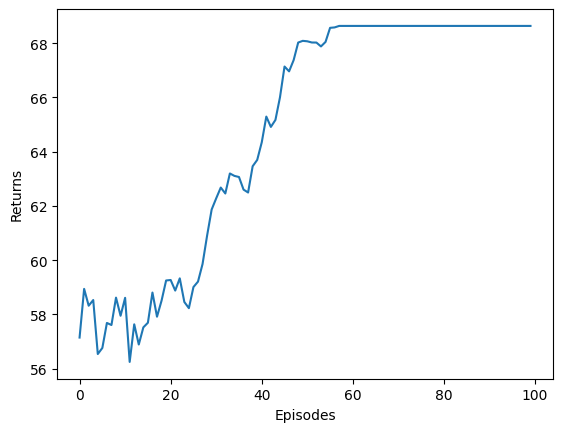

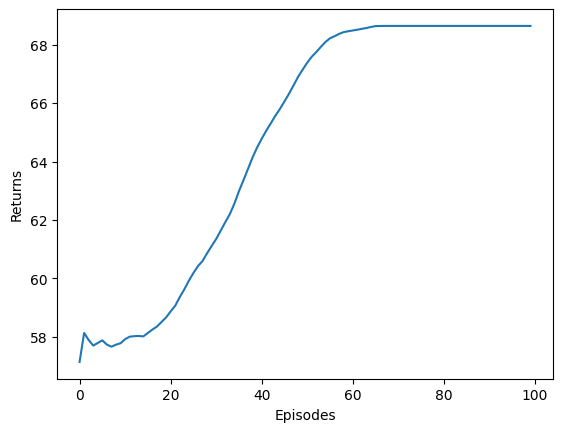

In [11]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, [x/epochs for x in return_list])
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.show()

mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(episodes_list, [x/epochs for x in mv_return])
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.show()